In [1]:
import ipywidgets as widgets
from scipy.stats import binom
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
import datetime

import re
import warnings
from IPython.display import HTML, display, clear_output
import sys
from scipy.optimize import curve_fit
from scipy import stats

import base64
import time

from random import choice, shuffle

warnings.filterwarnings('ignore')
%matplotlib inline

%config InlineBackend.figure_format = 'svg'

Forecasted_cases_df_for_download = []
model = str()

<img src="RUSH_full_color.jpg" style="float:left; margin:0px 0px 0px 0px" markdown="1" width="400"/>
<font size="5" color='green'>Center for Quality, Safety & Value Analytics</font>


[Click for instructions on using this calculator](https://webalyticos.home.blog/2020/03/24/covd19forecast/)

In [2]:
def obs_pred_rsquare(obs, pred):
    return 1 - sum((obs - pred) ** 2) / sum((obs - np.mean(obs)) ** 2)

################ Simple growth-based statistical models

def logistic(x, a, b, c):
    return a / (np.exp(-c * x) + b)


def get_logistic(obs_x, obs_y, ForecastDays):

    obs_x = np.array(obs_x)
    for i, val in enumerate(obs_y):
        if val == 0:
            try:
                obs_y[i] = obs_y[i-1]
            except:
                pass
    
    obs_y = np.array(obs_y)
    
    try:
        popt, pcov = curve_fit(logistic, obs_x, obs_y)
        pred_y = logistic(obs_x, *popt)
        forecasted_x = np.array(list(range(max(obs_x) + ForecastDays)))
        forecasted_y = logistic(forecasted_x, *popt)
        
    except:
        print('Logistic failed to fit. Using 2nd degree polynomial.')
        forecasted_y, forecasted_x, pred_y = get_polynomial(obs_x, obs_y, ForecastDays)
        
    return forecasted_y, forecasted_x, pred_y


def get_exponential(obs_x, obs_y, ForecastDays):
    
    obs_x = np.array(obs_x)
    
    for i, val in enumerate(obs_y):
        if val == 0:
            try:
                obs_y[i] = obs_y[i-1]
            except:
                pass       
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs_x, np.log(obs_y))
    obs_y = np.array(obs_y)
    
    pred_y = np.exp(intercept + slope*obs_x)
    forecasted_x = np.array(list(range(max(obs_x) + ForecastDays)))
    forecasted_y = np.exp(intercept + slope*forecasted_x)
    
    return forecasted_y, forecasted_x, pred_y
        


def get_polynomial(obs_x, obs_y, ForecastDays):
    
    obs_x = np.array(obs_x)
    for i, val in enumerate(obs_y):
        if val == 0:
            try:
                obs_y[i] = obs_y[i-1]
            except:
                pass       
    
    obs_y = np.array(obs_y)
    forecasted_y = np.zeros(len(obs_y))
    try:
        z = np.polyfit(obs_x, obs_y, 2)
        p = np.poly1d(z)
        pred_y = p(obs_x)
            
        forecasted_x = np.array(list(range(max(obs_x) + ForecastDays)))
        forecasted_y = p(forecasted_x)
    except:
        pass
    
    return forecasted_y, forecasted_x, pred_y



def fit_curve(obs_x, obs_y, model, df_sub, ForecastDays, N, T0, incubation_period, infectious_period, rho, socdist):

    obs_x = list(range(len(obs_y)))
    obs_x = np.array(obs_x)
    obs_y = np.array(obs_y)
    
    best_loc = str()
    
    if model == 'logistic':
        forecasted_y, forecasted_x, pred_y = get_logistic(obs_x, obs_y, ForecastDays)
        obs_pred_r2 = obs_pred_rsquare(obs_y, pred_y)
    elif model == 'exponential':
        forecasted_y, forecasted_x, pred_y = get_exponential(obs_x, obs_y, ForecastDays)
        obs_pred_r2 = obs_pred_rsquare(obs_y, pred_y)
    elif model == 'polynomial':
        forecasted_y, forecasted_x, pred_y = get_polynomial(obs_x, obs_y, ForecastDays)
        obs_pred_r2 = obs_pred_rsquare(obs_y, pred_y)
        
    elif model == 'SEIR-SD':
        # This model is derived from: https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296
        
        # Define parameters
        today = pd.to_datetime('today', format='%Y/%m/%d')
        if T0 is None:
            d1 = pd.to_datetime('2020/01/26', format='%Y/%m/%d')
        else:
            d1 = pd.to_datetime(T0, format='%Y-%m-%d')
            
        t_max = (today-d1).days
        t_max += ForecastDays
        
        init_vals = 1 - 1/N, 1/N, 0, 0

        alpha = 1/incubation_period 
        gamma = 1/infectious_period
        beta = gamma*rho
        params = alpha, beta, gamma, rho
        t = list(range(t_max))
        
        forecasted_y, forecasted_x, pred_y = seir_sd(obs_x, obs_y, ForecastDays,
                                        init_vals, params, N, t, socdist)
        
        obs_pred_r2 = obs_pred_rsquare(obs_y, pred_y)
        
    return obs_pred_r2, model, best_loc, obs_x, pred_y, forecasted_x, forecasted_y



#################### Epidemiological models

def seir_sd(obs_x, obs_y, ForecastDays, init_vals, params, N, t, socdist):
    # This model is derived from: https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296
    
    obs_x = np.array(obs_x)
    for i, val in enumerate(obs_y):
        if val == 0:
            try:
                obs_y[i] = obs_y[i-1]
            except:
                pass       
    
    
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R, Ir = [S_0], [E_0], [I_0], [R_0], [I_0]
    alpha, beta, gamma, rho = params
    i = 1
    
    for j in t[1:]:
        
        I_N = I[-1]/N
        sd = 0.0000000001 * (101 - socdist)
        sd = sd/(sd + I_N)
        beta = beta * sd
        #print(beta)
        
        next_S = ((S[-1] - (beta*S[-1]*I[-1])))
        next_E = (E[-1] + (beta*S[-1]*I[-1] - alpha * E[-1]))
        
        next_I = I[-1] + (alpha*E[-1] - gamma * I[-1])
        next_R = R[-1] + (gamma*I[-1]) 
        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        
        test_lag = 1/(1+np.exp(-0.1*j+5))
        Ir.append(next_I * test_lag)
        
                
    I = np.array(Ir)*N
    forecasted_y = I.tolist()
    
    num = len(obs_y)+ForecastDays
    pred_y = forecasted_y[-num+1:-ForecastDays+1]
    pred_y = np.array(pred_y)
    
    forecasted_y = forecasted_y[-num+1:]
    forecasted_y = np.array(forecasted_y)
    forecasted_x = np.array(range(len(forecasted_y)))
    
    return forecasted_y, forecasted_x, pred_y


In [4]:
class App_GetFits:
    global Forecasted_cases_df_for_download
    global model
    
    def __init__(self, df):
        
        # model: 'logistic'; 'exponential'; 'polynomial';
        # query: Any location available within the dataframe
        # refer: Any location available within the dataframe
        
        self._df = df
        available_indicators2 = list(set(self._df['Province/State']))
        available_indicators2.sort()
        
        self._1_dropdown = self._create_dropdown(['logistic', 'exponential', 'polynomial', 
                                                  'SEIR-SD'],
                                                 1, label = 'Choose a model to fit:')
        self._2_dropdown = self._create_dropdown(available_indicators2, 17, label = 'Choose a location:')
        self._3_floattext = self._create_floattext(label = '% Visiting your hospital:', 
                                                   val=10, minv=0, maxv=100, boxw='33%', desw='70%')
        self._4_floattext = self._create_floattext(label = '% Admitted to your hospital:', 
                                                   val=30, minv=0, maxv=100, boxw='33%', desw='70%')
        self._5_floattext = self._create_floattext(label = '% Admitted to critical care:', 
                                                   val=25, minv=0, maxv=100, boxw='33%', desw='70%')
        self._6_floattext = self._create_floattext(label = 'LOS (non-critical care):', 
                                                   val=3, minv=1, maxv=180, boxw='33%', desw='70%')
        self._7_floattext = self._create_floattext(label = 'LOS (critical care):', 
                                                   val=12, minv=1, maxv=180, boxw='33%', desw='70%')
        self._8_floattext = self._create_floattext(label = '% of ICU on vent:',
                                                   val=60, minv=0, maxv=100, boxw='33%', desw='70%')
        self._9_toggle = self._create_toggle()
        
        self._10_floattext = self._create_floattext(label = 'GLOVE SURGICAL', 
                                                    val=2, minv=0, maxv=1000, boxw='33%', desw='70%')
        self._11_floattext = self._create_floattext(label = 'GLOVE EXAM NITRILE', 
                                                    val=260, minv=0, maxv=1000, boxw='33%', desw='70%')
        self._12_floattext = self._create_floattext(label = 'GLOVE EXAM VINYL', 
                                                    val=10, minv=0, maxv=1000, boxw='33%', desw='70%')
        self._13_floattext = self._create_floattext(label = 'MASK FACE PROC. ANTI FOG', 
                                                    val=45, minv=0, maxv=1000, boxw='33%', desw='70%')
        self._14_floattext = self._create_floattext(label = 'MASK PROC. FLUID RESISTANT', 
                                                    val=1, minv=0, maxv=1000, boxw='33%', desw='70%')
        self._15_floattext = self._create_floattext(label = 'GOWN ISOLATION XL YELLOW', 
                                                    val=2, minv=0, maxv=1000, boxw='33%', desw='70%')
        self._16_floattext = self._create_floattext(label = 'MASK SURG. ANTI FOG W/FILM', 
                                                    val=1, minv=0, maxv=1000, boxw='33%', desw='70%')
        self._17_floattext = self._create_floattext(label = 'SHIELD FACE FULL ANTI FOG', 
                                                    val=1, minv=0, maxv=1000, boxw='33%', desw='70%')
        self._18_floattext = self._create_floattext(label = 'RESP. PART. FILTER REG', 
                                                    val=11, minv=0, maxv=1000, boxw='33%', desw='70%')
        
        self._19_floattext = self._create_floattext(label = 'Forecast length (days)', 
                                                    val=10, minv=1, maxv=30, boxw='33%', desw='70%')
        
        self._20_floattext = self._create_floattext(label = 'Focal population size', 
                                                    val=12740000, minv=1, maxv=10**8, boxw='50%', desw='50%')
        self._22_floattext = self._create_floattext(label = 'Incubation period', 
                                                    val=5, minv=1, maxv=21, boxw='50%', desw='50%')
        self._23_floattext = self._create_floattext(label = 'Infectious period', 
                                                    val=7, minv=1, maxv=21, boxw='50%', desw='50%')
        self._24_floattext = self._create_floattext(label = 'Reproduction no.', 
                                                    val=4, minv=1, maxv=21, boxw='50%', desw='50%')
        self._25_floattext = self._create_floattext(label = 'Social Distancing: 1 - 100', 
                                                    val=7, minv=0, maxv=100, boxw='50%', desw='50%')
        self._26_floattext = self._create_floattext(label = 'Time lag (days)', 
                                                    val=0, minv=0, maxv=14, boxw='33%', desw='70%')
        
        self._21_datepickr = self._create_datepickr(label='Likely date of 1st exposure', boxw='49%', desw='51%')
        
        
        
        self._plot_container = widgets.Output()
        
        _app_container = widgets.VBox(
            [widgets.VBox([widgets.HBox([self._9_toggle, self._1_dropdown, self._2_dropdown], 
                             layout=widgets.Layout(align_items='flex-start', flex='0 auto auto', width='100%')),
                           
                           widgets.HBox([self._3_floattext, self._4_floattext, self._5_floattext],
                             layout=widgets.Layout(align_items='flex-start', flex='0 0 auto', width='100%')),
                           
                           widgets.HBox([self._6_floattext, self._7_floattext, self._8_floattext],
                             layout=widgets.Layout(align_items='flex-start', flex='0 0 auto', width='100%')),
                          
                           widgets.HBox([self._10_floattext, self._11_floattext, self._12_floattext],
                             layout=widgets.Layout(align_items='flex-start', flex='0 0 auto', width='100%')),
                           
                           widgets.HBox([self._13_floattext, self._14_floattext, self._15_floattext],
                             layout=widgets.Layout(align_items='flex-start', flex='0 0 auto', width='100%')),
                           
                           widgets.HBox([self._16_floattext, self._17_floattext, self._18_floattext],
                             layout=widgets.Layout(align_items='flex-start', flex='0 0 auto', width='100%')),
                          
                           widgets.HBox([self._19_floattext, self._26_floattext],
                             layout=widgets.Layout(align_items='flex-start', flex='0 0 auto', width='100%'))],
                           
                           layout=widgets.Layout(display='flex', flex_flow='column', border='solid 1px', 
                                        align_items='stretch', width='100%')),
             
             widgets.VBox([widgets.HBox([self._20_floattext, self._22_floattext],
                             layout=widgets.Layout(align_items='flex-start', flex='0 0 auto', width='100%')),
                           widgets.HBox([self._23_floattext, self._24_floattext],
                             layout=widgets.Layout(align_items='flex-start', flex='0 0 auto', width='100%')),
                           widgets.HBox([self._25_floattext, self._21_datepickr],
                             layout=widgets.Layout(align_items='flex-start', flex='0 0 auto', width='100%'))],
                           
                           layout=widgets.Layout(display='flex', flex_flow='column', border='solid 1px', 
                                        align_items='stretch', width='100%')),
                           self._plot_container], layout=widgets.Layout(display='flex', flex_flow='column', 
                                        border='solid 2px', align_items='initial', width='100%'))
                
        # 'flex-start', 'flex-end', 'center', 'baseline', 'stretch', 'inherit', 'initial', 'unset'
        self.container = widgets.VBox([
            widgets.HBox([
                _app_container
            ])
        ], layout=widgets.Layout(max_width='1024px'))
        self._update_app()
        
        
    @classmethod
    def from_url(cls):
        df = pd.read_csv('COVID-CASES-DF.txt', sep='\t')  
        df = df[df['Country/Region'] == 'US']
        df = df[df['Province/State'] != 'US']
        return cls(df)
        
        
    def _create_dropdown(self, indicators, initial_index, label):
        dropdown = widgets.Dropdown(options=indicators, 
                                    layout={'width': '60%'},
                                    style={'description_width': '49%'},
                                    value=indicators[initial_index],
                                   description=label)
        
        dropdown.observe(self._on_change, names=['value'])
        return dropdown
    
    def _create_floattext(self, label, val, minv, maxv, boxw, desw):
        obj = widgets.BoundedFloatText(
                    value=val,
                    min=minv,
                    max=maxv,
                    description=label,
                    disabled=False,
                    layout={'width': boxw},
                    style={'description_width': desw},
                )
        obj.observe(self._on_change, names=['value'])
        return obj
    
    
    
    def _create_toggle(self): 
        obj = widgets.ToggleButton(
                    value=False,
                    description='log-scale',
                    disabled=False,
                    button_style='', # 'success', 'info', 'warning', 'danger' or ''
                    tooltip='Description',
                    icon='check' # (FontAwesome names without the `fa-` prefix)
                )
        obj.observe(self._on_change, names=['value'])
        return obj
    
    
    def _create_datepickr(self, label, boxw, desw): 
        obj = widgets.DatePicker(
                    description=label,
                    disabled=False,
                    layout={'width': boxw},
                    style={'description_width': desw},
                )
        obj.observe(self._on_change, names=['value'])
        return obj
                
    
    
    def _on_change(self, _):
        self._update_app()

    def _update_app(self):
        global model
        
        model = self._1_dropdown.value
        focal_loc = self._2_dropdown.value
        per_loc  = self._3_floattext.value
        per_admit = self._4_floattext.value
        per_cc = self._5_floattext.value
        LOS_nc = self._6_floattext.value
        LOS_cc = self._7_floattext.value
        per_vent = self._8_floattext.value
        log_scl = self._9_toggle.value
        
        ppe_GLOVE_SURGICAL = self._10_floattext.value
        ppe_GLOVE_EXAM_NITRILE = self._11_floattext.value
        ppe_GLOVE_GLOVE_EXAM_VINYL = self._12_floattext.value
        ppe_MASK_FACE_PROCEDURE_ANTI_FOG= self._13_floattext.value
        ppe_MASK_PROCEDURE_FLUID_RESISTANT = self._14_floattext.value
        ppe_GOWN_ISOLATION_XLARGE_YELLOW= self._15_floattext.value
        ppe_MASK_SURGICAL_ANTI_FOG_W_FILM = self._16_floattext.value
        ppe_SHIELD_FACE_FULL_ANTI_FOG = self._17_floattext.value
        ppe_RESPIRATOR_PARTICULATE_FILTER_REG = self._18_floattext.value
        ForecastDays = self._19_floattext.value
        State_Pop_Size = self._20_floattext.value
        T0 = self._21_datepickr.value
        Incubation = self._22_floattext.value
        Infectious = self._23_floattext.value
        Rho = self._24_floattext.value
        SocialDist = self._25_floattext.value
        TimeLag = self._26_floattext.value
        
        
        
        
        
        self._plot_container.clear_output(wait=True)
        with self._plot_container:
            self._get_fit(model, focal_loc, per_loc, per_admit, per_cc, LOS_cc, LOS_nc, per_vent, log_scl,
                         ppe_GLOVE_SURGICAL, ppe_GLOVE_EXAM_NITRILE, ppe_GLOVE_GLOVE_EXAM_VINYL,
                         ppe_MASK_FACE_PROCEDURE_ANTI_FOG, ppe_MASK_PROCEDURE_FLUID_RESISTANT, 
                         ppe_GOWN_ISOLATION_XLARGE_YELLOW, ppe_MASK_SURGICAL_ANTI_FOG_W_FILM,
                         ppe_SHIELD_FACE_FULL_ANTI_FOG, ppe_RESPIRATOR_PARTICULATE_FILTER_REG,
                         ForecastDays, State_Pop_Size, T0, Incubation, Infectious, Rho, SocialDist,
                         TimeLag)
            
            plt.show()
            
            
    def _get_fit(self, model, focal_loc, per_loc, per_admit, per_cc, LOS_cc, LOS_nc, per_vent, log_scl,
                        ppe_GLOVE_SURGICAL, ppe_GLOVE_EXAM_NITRILE, ppe_GLOVE_GLOVE_EXAM_VINYL,
                        ppe_MASK_FACE_PROCEDURE_ANTI_FOG, ppe_MASK_PROCEDURE_FLUID_RESISTANT, 
                        ppe_GOWN_ISOLATION_XLARGE_YELLOW, ppe_MASK_SURGICAL_ANTI_FOG_W_FILM,
                        ppe_SHIELD_FACE_FULL_ANTI_FOG, ppe_RESPIRATOR_PARTICULATE_FILTER_REG,
                        ForecastDays, State_Pop_Size, T0, Incubation, Infectious, Rho, SocialDist,
                        TimeLag):
        
        global Forecasted_cases_df_for_download
        ForecastDays = int(ForecastDays+1)
        
        fig = plt.figure(figsize=(11, 17))
        ax = plt.subplot2grid((6, 4), (0, 0), colspan=2, rowspan=2)
        
        df_sub = self._df[self._df['Province/State'] == focal_loc]
        df_sub = df_sub.loc[:, (df_sub != 0).any(axis=0)]
        yi = list(df_sub)
        
        clrs =  ['mistyrose', 'pink', 'lightcoral', 'salmon', 'red']
        clrs2 = ['powderblue', 'lightskyblue', 'cornflowerblue', 'dodgerblue', 'blue']
        
        for i, j in enumerate([-4,-3,-2,-1, 0]):
            if j == 0:
                DATES = yi[4:]
                focal = df_sub.iloc[0,4:].values
            else:
                DATES = yi[4:j]
                focal = df_sub.iloc[0,4:j].values
            
            if model == 'SEIR-SD':
                DATES = yi[4:]
                focal = df_sub.iloc[0,4:].values
            
            y = []
            dates = []
            for ii, val in enumerate(focal):
                if len(y) > 0 or val > 0:
                    y.append(val)
                    dates.append(DATES[ii])

            x = list(range(len(y)))

            obs_pred_r2_G, model_G, loc_G, obs_x_G, pred_y_G, forecasted_x_G, forecasted_y_G = fit_curve(x, y, 
                                                                model, df_sub, ForecastDays, State_Pop_Size,
                                                                T0, Incubation, Infectious, Rho, SocialDist)
            obs_y_G = np.array(list(y))

            if obs_pred_r2_G < 0:
                obs_pred_r2_G = 0.0

            y = np.array(y)
            y[y < 0] = 0
            pred_y_G = np.array(pred_y_G)
            pred_y_G[pred_y_G < 0] = 0

            forecasted_y_G = np.array(forecasted_y_G)
            forecasted_y_G[forecasted_y_G < 0] = 0
            forecast_vals = np.copy(forecasted_y_G)

            numdays = len(forecasted_x_G)
            latest_date = pd.to_datetime(dates[-1])
            first_date = pd.to_datetime(dates[0])

            future_date = latest_date + datetime.timedelta(days = ForecastDays-1)
            fdates = pd.date_range(start=first_date, end=future_date)
            fdates = fdates.strftime('%m/%d')
            
            do = -j
            if do == 0:
                label='Current forecast'
                if model == 'SEIR-SD':
                    label = 'Forecast\n'
            elif model != 'SEIR-SD':
                label = str(do)+' day old forecast'
            elif model == 'SEIR-SD':
                label = None
            lw = 3
            
            plt.plot(fdates, forecasted_y_G, c=clrs[i], linewidth=lw, label=label)
            
            latest_date = pd.to_datetime(dates[-1])
            first_date = pd.to_datetime(dates[0])
            dates = pd.date_range(start=first_date, end=latest_date)
            dates = dates.strftime('%m/%d')
            plt.plot(dates, pred_y_G, c=clrs2[i], linewidth=lw)
            plt.scatter(dates, y, c='0.2', s=100, alpha=0.8, linewidths=0.1)
            
            
        forecast_vals = forecast_vals.tolist()

        new_cases = []
        for i, val in enumerate(forecast_vals):
            if i > 0:
                if forecast_vals[i] - forecast_vals[i-1] > 0:
                    new_cases.append(forecast_vals[i] - forecast_vals[i-1])
                else:
                    new_cases.append(0)
            if i == 0:
                new_cases.append(forecast_vals[i])

        leg = ax.legend(handlelength=0, handletextpad=0, fancybox=False,
                        loc=2, frameon=False, fontsize=12)

        for line,text in zip(leg.get_lines(), leg.get_texts()):
            text.set_color(line.get_color())

        for item in leg.legendHandles: 
            item.set_visible(False)

        plt.xticks(rotation=35, ha='center')
        plt.xlabel('Date', fontsize=14, fontweight='bold')
        plt.ylabel('Confirmed cases', fontsize=14, fontweight='bold')
        
        if log_scl == True:
            plt.yscale('log')

        if len(forecasted_x_G) < 10:
            i = 1
        elif len(forecasted_x_G) < 20:
            i = 4
        elif len(forecasted_x_G) < 40:
            i = 6
        else:
            i = 8

        for label in ax.xaxis.get_ticklabels()[::i]:
            label.set_visible(False)

        ax = plt.gca()
        temp = ax.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::i]))
        for label in temp:
            label.set_visible(False)
        
        if model == 'SEIR-SD':
            label = 'Model fitting, current ' + r'$r^{2}$' + ' = ' + str(np.round(obs_pred_r2_G, 2))
            label += '\n(model under development)'
            plt.title(label, fontsize = 14, fontweight = 'bold')
        else:
            plt.title('Model fitting, current ' + r'$r^{2}$' + ' = ' + str(np.round(obs_pred_r2_G, 2)), fontsize = 16, fontweight = 'bold')
        
        
        
        
        ax = plt.subplot2grid((6, 4), (0, 2), colspan=2, rowspan=2)
        ax.axis('off')

        loc = str(focal_loc)
        if len(loc) > 12:
            loc = loc[:12]
            loc = loc + '...'

        col_labels = ['Total cases', 'New cases', 'New visits', 'New admits']

        row_labels = fdates.tolist()
        new_cases = np.round(new_cases, 1)
        
        row_labels = row_labels[-(ForecastDays):]
        new_cases2 = new_cases[ -(ForecastDays):]
        sub_f = forecasted_y_G[ -(ForecastDays):]

        table_vals = []
        cclr_vals = []
        rclr_vals = []
        
        ## Inclusion of time lag
        #lag_pop = 
        #for i, val in enumerate(new_cases):
            
        
        
        Forecasted_cases_df_for_download = pd.DataFrame(columns = ['date'] + col_labels)
        for i in range(len(row_labels)):
            
            val = new_cases2[i]
            cell = [int(np.round(sub_f[i])), 
                    int(np.round(val)), 
                    int(np.round(val * (per_loc * 0.01))),
                    int(np.round((0.01 * per_admit) * val * (per_loc * 0.01)))]
            
            df_row = [row_labels[i]]
            df_row.extend(cell)
            
            labs = ['date'] + col_labels
            temp = pd.DataFrame([df_row], columns=labs)
            Forecasted_cases_df_for_download = pd.concat([Forecasted_cases_df_for_download, temp])
            
            
            if i == 0:
                rclr = '0.8'
                cclr = ['0.8', '0.8', '0.8', '0.8']
            else:
                rclr = 'w'
                cclr = ['w', 'w', 'w', 'w']
            table_vals.append(cell)
            cclr_vals.append(cclr)
            rclr_vals.append(rclr)

        ncol = 4
        lim = ForecastDays
        if lim > 18:
            lim = 19
            
        the_table = plt.table(cellText=table_vals[0:lim],
                        colWidths=[0.32, 0.32, 0.32, 0.32],
                        rowLabels=row_labels[0:lim],
                        colLabels=col_labels,
                        cellLoc='center',
                        loc='upper center',
                        cellColours=cclr_vals[0:lim],
                        rowColours =rclr_vals[0:lim])
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(10)
        the_table.scale(1, 1.32)
        
        if ForecastDays <= 18:
            plt.title('Forecasted cases for '+ loc, fontsize = 16, fontweight = 'bold')
        elif ForecastDays > 18:
            titletext = 'Forecasted cases for '+ loc + '\ndata beyond 18 days is available in the csv (below)'
            plt.title(titletext, fontsize = 14, fontweight = 'bold')
            
        
        
        ax = plt.subplot2grid((6, 4), (2, 0), colspan=2, rowspan=2)
        
        #### Construct arrays for critical care and non-critical care patients
        cc = (0.01 * per_cc) * (0.01 * per_admit) * (0.01 * per_loc) * np.array(new_cases)
        cc = cc.tolist()

        
        nc = (1 - (0.01 * per_cc)) * (0.01 * per_admit) * (0.01 * per_loc) * np.array(new_cases)
        nc = nc.tolist()
        
        # LOS for non critical care = 5 days
        # LOS for critical care = 10 days
        p = 0.5
        n_cc = LOS_cc*2
        n_nc = LOS_nc*2
        
        rv_nc = binom(n_nc, p)
        p_nc = rv_nc.cdf(np.array(range(1, len(fdates)+1)))
        
        rv_cc = binom(n_cc, p)
        p_cc = rv_cc.cdf(np.array(range(1, len(fdates)+1)))
        
        LOScc = np.zeros(len(fdates))
        LOScc[0] = new_cases[0] * (0.01 * per_cc) * (0.01 * per_admit) * (0.01 * per_loc)
        LOSnc = np.zeros(len(fdates))
        LOSnc[0] =  new_cases[0] * (1-(0.01 * per_cc)) * (0.01 * per_admit) * (0.01 * per_loc)
        
        
        total_nc = []
        total_cc = []
        
        
        for i, day in enumerate(fdates):
            LOScc = LOScc * (1 - p_cc)
            LOSnc = LOSnc * (1 - p_nc)
            
            LOScc = np.roll(LOScc, shift=1)
            LOSnc = np.roll(LOSnc, shift=1)
            
            LOScc[0] = new_cases[i] * (0.01 * per_cc) * (0.01 * per_admit) * (0.01 * per_loc)
            LOSnc[0] = new_cases[i] * (1 - (0.01 * per_cc)) * (0.01 * per_admit) * (0.01 * per_loc)
    
            total_nc.append(np.sum(LOSnc))
            total_cc.append(np.sum(LOScc))
            #print(day, '  :  ', np.round(LOScc, 0), '  :  ', sum(np.round(LOScc, 0)), '\n')
            
        
        plt.plot(fdates, total_cc, c='Crimson', label='Critical care', linewidth=3)
        plt.plot(fdates, total_nc, c='0.3', label='Non-critical care', linewidth=3)
        plt.title('Forecasted census', fontsize = 16, fontweight = 'bold')
        if log_scl == True:
            plt.yscale('log')
        
        for label in ax.xaxis.get_ticklabels()[::8]:
            label.set_visible(False)

        ax = plt.gca()
        temp = ax.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::8]))
        for label in temp:
            label.set_visible(False)
            
        leg = ax.legend(handlelength=0, handletextpad=0, fancybox=False,
                        loc='best', frameon=False, fontsize=14)

        for line,text in zip(leg.get_lines(), leg.get_texts()):
            text.set_color(line.get_color())

        for item in leg.legendHandles: 
            item.set_visible(False)
        
        plt.ylabel('COVID-19 patients', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=14, fontweight='bold')
        
        
        
        
        
        ax = plt.subplot2grid((6, 4), (2, 2), colspan=2, rowspan=2)
        
        ax.axis('off')
        #ax.axis('tight')

        if len(loc) > 12:
            loc = loc[:12]
            loc = loc + '...'

        col_labels = ['All COVID', 'Non-ICU', 'ICU', 'Vent']

        
        row_labels = fdates.tolist()
        row_labels = row_labels[-(ForecastDays):]
        total_nc_trunc = total_nc[-(ForecastDays):]
        total_cc_trunc = total_cc[-(ForecastDays):]
        
        table_vals = []
        cclr_vals = []
        rclr_vals = []
        for i in range(len(row_labels)):

            cell = [int(np.round(total_nc_trunc[i] + total_cc_trunc[i])), 
                    int(np.round(total_nc_trunc[i])),
                    int(np.round(total_cc_trunc[i])), 
                    int(np.round(total_cc_trunc[i]*(0.01*per_vent)))]
            
            if i == 0:
                rclr = '0.8'
                cclr = ['0.8', '0.8', '0.8', '0.8']
            else:
                rclr = 'w'
                cclr = ['w', 'w', 'w', 'w']
            table_vals.append(cell)
            cclr_vals.append(cclr)
            rclr_vals.append(rclr)
            
        ncol = 4
        lim = ForecastDays
        if lim > 18:
            lim = 19
            
        the_table = plt.table(cellText=table_vals[0:lim],
                        colWidths=[0.255, 0.255, 0.255, 0.255],
                        rowLabels=row_labels[0:lim],
                        colLabels=col_labels,
                        cellLoc='center',
                        loc='upper center',
                        cellColours=cclr_vals[0:lim],
                        rowColours =rclr_vals[0:lim])
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(10)
        the_table.scale(1, 1.32)
        
        if ForecastDays <= 18:
            plt.title('Beds needed for COVID-19 cases', fontsize = 16, fontweight = 'bold')
        elif ForecastDays > 18:
            titletext = 'Beds needed for COVID-19 cases' + '\ndata beyond 18 days is available in the csv (below)'
            plt.title(titletext, fontsize = 14, fontweight = 'bold')
            
        
        
        
        
        
        
        
        ####################### PPE ##################################
        ax = plt.subplot2grid((6, 4), (4, 0), colspan=2, rowspan=2)
        
        #### Construct arrays for critical care and non-critical care patients
        
        # All covid patients expected in house on each forecasted day. PUI is just a name here
        PUI_COVID = np.array(total_nc) + np.array(total_cc) 
        # Preparing to add new visits, fraction of new cases visiting your hospital = 0.01 * per_loc 
        new_visits_your_hospital = new_cases * (0.01 * per_loc)
        # Add number of new visits to number of in house patients
        PUI_COVID = PUI_COVID + new_visits_your_hospital
        
        glove_surgical = np.round(ppe_GLOVE_SURGICAL * PUI_COVID).astype('int')
        glove_nitrile = np.round(ppe_GLOVE_EXAM_NITRILE * PUI_COVID).astype('int')
        glove_vinyl = np.round(ppe_GLOVE_GLOVE_EXAM_VINYL * PUI_COVID).astype('int')
        face_mask = np.round(ppe_MASK_FACE_PROCEDURE_ANTI_FOG * PUI_COVID).astype('int')
        procedure_mask = np.round(ppe_MASK_PROCEDURE_FLUID_RESISTANT * PUI_COVID).astype('int')
        isolation_gown = np.round(ppe_GOWN_ISOLATION_XLARGE_YELLOW * PUI_COVID).astype('int')
        surgical_mask = np.round(ppe_MASK_SURGICAL_ANTI_FOG_W_FILM * PUI_COVID).astype('int')
        face_shield = np.round(ppe_SHIELD_FACE_FULL_ANTI_FOG * PUI_COVID).astype('int')
        respirator = np.round(ppe_RESPIRATOR_PARTICULATE_FILTER_REG * PUI_COVID).astype('int')
        
        
        ppe_ls =[[glove_surgical, 'GLOVE SURGICAL', 'r'],
             [glove_nitrile, 'GLOVE EXAM NITRILE', 'orange'],
             [glove_vinyl, 'GLOVE EXAM VINYL', 'goldenrod'],
             [face_mask, 'MASK FACE PROCEDURE ANTI FOG', 'limegreen'],
             [procedure_mask, 'MASK PROCEDURE FLUID RESISTANT', 'green'],
             [isolation_gown, 'GOWN ISOLATION XLARGE YELLOW', 'cornflowerblue'],
             [surgical_mask, 'MASK SURGICAL ANTI FOG W/FILM', 'blue'],
             [face_shield, 'SHIELD FACE FULL ANTI FOG', 'plum'],
             [respirator, 'RESPIRATOR PARTICULATE FILTER REG', 'darkviolet']]
        
        linestyles = ['dashed', 'dotted', 'dashdot', 
                      'dashed', 'dotted', 'dashdot',
                      'dotted', 'dashed', 'dashdot']
        
        for i, ppe in enumerate(ppe_ls):
            plt.plot(fdates, ppe[0], c=ppe[2], label=ppe[1], linewidth=2, ls=linestyles[i])
    
        plt.title('Forecasted PPE needs', fontsize = 16, fontweight = 'bold')
        #if log_scl == True:
        #    plt.yscale('log')
        
        for label in ax.xaxis.get_ticklabels()[::8]:
            label.set_visible(False)

        ax = plt.gca()
        temp = ax.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::8]))
        for label in temp:
            label.set_visible(False)
            
        leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True,
                        loc=2, frameon=True, fontsize=8)

        for line,text in zip(leg.get_lines(), leg.get_texts()):
            text.set_color(line.get_color())

        for item in leg.legendHandles: 
            item.set_visible(False)
        
        plt.ylabel('PPE Supplies', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=14, fontweight='bold')
        if log_scl == True:
            plt.yscale('log')
        
        
        
        
        
        ax = plt.subplot2grid((6, 4), (4, 2), colspan=2, rowspan=2)
        ax.axis('off')
        #ax.axis('tight')
        
        #### Construct arrays for critical care and non-critical care patients
        #PUI_COVID = np.array(total_nc) + np.array(total_cc)
        PUI_COVID = PUI_COVID[-(ForecastDays):]
        
        glove_surgical = np.round(ppe_GLOVE_SURGICAL * PUI_COVID).astype('int')
        glove_nitrile = np.round(ppe_GLOVE_EXAM_NITRILE * PUI_COVID).astype('int')
        glove_vinyl = np.round(ppe_GLOVE_GLOVE_EXAM_VINYL * PUI_COVID).astype('int')
        face_mask = np.round(ppe_MASK_FACE_PROCEDURE_ANTI_FOG * PUI_COVID).astype('int')
        procedure_mask = np.round(ppe_MASK_PROCEDURE_FLUID_RESISTANT * PUI_COVID).astype('int')
        isolation_gown = np.round(ppe_GOWN_ISOLATION_XLARGE_YELLOW * PUI_COVID).astype('int')
        surgical_mask = np.round(ppe_MASK_SURGICAL_ANTI_FOG_W_FILM * PUI_COVID).astype('int')
        face_shield = np.round(ppe_SHIELD_FACE_FULL_ANTI_FOG * PUI_COVID).astype('int')
        respirator = np.round(ppe_RESPIRATOR_PARTICULATE_FILTER_REG * PUI_COVID).astype('int')
        
        
        ppe_ls =[[glove_surgical, 'GLOVE SURGICAL', 'r'],
             [glove_nitrile, 'GLOVE EXAM NITRILE', 'orange'],
             [glove_vinyl, 'GLOVE EXAM VINYL', 'goldenrod'],
             [face_mask, 'MASK FACE PROCEDURE ANTI FOG', 'limegreen'],
             [procedure_mask, 'MASK PROCEDURE FLUID RESISTANT', 'green'],
             [isolation_gown, 'GOWN ISOLATION XLARGE YELLOW', 'cornflowerblue'],
             [surgical_mask, 'MASK SURGICAL ANTI FOG W/FILM', 'blue'],
             [face_shield, 'SHIELD FACE FULL ANTI FOG', 'plum'],
             [respirator, 'RESPIRATOR PARTICULATE FILTER REG', 'darkviolet']]
        
        
        if len(loc) > 12:
            loc = loc[:12]
            loc = loc + '...'

        col_labels = [ppe_ls[0][1], ppe_ls[1][1], ppe_ls[2][1], 
                      ppe_ls[3][1], ppe_ls[4][1], ppe_ls[5][1],
                      ppe_ls[6][1], ppe_ls[7][1], ppe_ls[8][1]]

        row_labels = fdates.tolist()        
        row_labels = row_labels[-(ForecastDays):]
        
        table_vals = []
        cclr_vals = []
        rclr_vals = []
        for i in range(len(row_labels)):
                
            cell = [ppe_ls[0][0][i], ppe_ls[1][0][i], ppe_ls[2][0][i], 
                      ppe_ls[3][0][i], ppe_ls[4][0][i], ppe_ls[5][0][i],
                      ppe_ls[6][0][i], ppe_ls[7][0][i], ppe_ls[8][0][i]]
            
            if i == 0:
                rclr = '0.8'
                cclr = ['0.8', '0.8', '0.8', '0.8', '0.8', '0.8', '0.8', '0.8', '0.8']
            else:
                rclr = 'w'
                cclr = ['w', 'w', 'w', 'w', 'w', 'w', 'w', 'w', 'w']
                
            table_vals.append(cell)
            cclr_vals.append(cclr)
            rclr_vals.append(rclr)
            
        ncol = 9
        cwp = 0.15
        lim = ForecastDays
        if lim > 18:
            lim = 19
            
        the_table = plt.table(cellText=table_vals[0:lim],
                        colWidths=[cwp]*9,
                        rowLabels=row_labels[0:lim],
                        colLabels=None,
                        cellLoc='center',
                        loc='upper center',
                        cellColours=cclr_vals[0:lim],
                        rowColours =rclr_vals[0:lim])
        
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(10)
        the_table.scale(1, 1.32)
        
        for i in range(len(ppe_ls)):
            clr = ppe_ls[i][2]
            for j in range(lim):
                the_table[(j, i)].get_text().set_color(clr)
        
        hoffset = -0.4 #find this number from trial and error
        voffset = 1.0 #find this number from trial and error
        col_width = [0.06, 0.09, 0.09, 0.12, 0.133, 0.138, 0.128, 0.135, 0.142]
        
        col_labels2 =[['GLOVE SURGICAL', 'r'],
             ['GLOVE EXAM NITRILE', 'orange'],
             ['GLOVE GLOVE EXAM VINYL', 'goldenrod'],
             ['MASK FACE PROC. A-FOG', 'limegreen'],
             ['MASK PROC. FLUID RES.', 'green'],
             ['GOWN ISO. XL YELLOW', 'cornflowerblue'],
             ['MASK SURG. ANTI FOG W/FILM', 'blue'],
             ['SHIELD FACE FULL ANTI FOG', 'plum'],
             ['RESP. PART. FILTER REG', 'darkviolet']]
        
        count=0
        for i, val in enumerate(col_labels2):
            ax.annotate('  '+val[0], xy=(hoffset + count * col_width[i], voffset),
            xycoords='axes fraction', ha='left', va='bottom', 
            rotation=-25, size=8, c=val[1])
            count+=1
        
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=1.1, hspace=1.1)
        

In [5]:
app1 = App_GetFits.from_url()

grid = widgets.GridspecLayout(1, 1)
grid[0, 0] = app1.container

app_contents = [grid]
app = widgets.VBox(app_contents, layout=widgets.Layout(align_items='center'))

display(app)

In [6]:

class App_GetCSV:
    global Forecasted_cases_df_for_download
    
    def __init__(self, df):
        
        self._df = df
        self._csv_toggle = self._create_toggle()
        self._plot_container = widgets.Output()
        
        _app_container = widgets.VBox(
            [widgets.VBox([widgets.HBox([self._csv_toggle], 
                             layout=widgets.Layout(align_items='flex-start', flex='0 auto auto', width='100%'))]),
                           self._plot_container], layout=widgets.Layout(display='flex', flex_flow='column', 
                                        border='solid 2px', align_items='stretch', width='100%'))
        
        # 'flex-start', 'flex-end', 'center', 'baseline', 'stretch', 'inherit', 'initial', 'unset'
        self.container = widgets.VBox([
            widgets.HBox([
                _app_container
            ])
        ], layout=widgets.Layout(max_width='1024px'))
        self._update_app()
        
        
    @classmethod
    def from_url(cls):
        df = pd.read_csv('COVID-CASES-DF.txt', sep='\t')  
        #df = df[df['Country/Region'] == 'US']
        return cls(df)
    
    
    def _create_toggle(self): 
        obj = widgets.ToggleButton(
                    value=False,
                    description='generate csv',
                    disabled=False,
                    button_style='', # 'success', 'info', 'warning', 'danger' or ''
                    tooltip='Description',
                    icon='check' # (FontAwesome names without the `fa-` prefix)
                )
        obj.observe(self._on_change, names=['value'])
        return obj
    
    def _create_download_link(self, make_csv, df, title, filename):
        if make_csv == True:
            csv = df.to_csv()
            b64 = base64.b64encode(csv.encode())
            payload = b64.decode()
            html = '<a download="{filename}" href="data:text/csv;base64,{payload}" style="left; margin:0px 0px 0px 0px" size="4" target="_blank">{title}</a>'
            html = html.format(payload=payload,title=title,filename=filename)
            display(HTML(html))
            print('CSV File will clear after 4 seconds')
            time.sleep(4)
            clear_output()
        elif make_csv == False:
            try:
                clear_output()
            except:
                pass
        

    def _on_change(self, _):
        self._update_app()

    def _update_app(self):
        global Forecasted_cases_df_for_download
        global model
        
        make_csv = self._csv_toggle.value
        
        self._plot_container.clear_output(wait=True)
        with self._plot_container:
            self._create_download_link(make_csv, Forecasted_cases_df_for_download, 
                                       "Download CSV file of forecasted COVID-19 cases for " + model + " model", 
                                       "forecasted_COVID19_cases.csv")

In [7]:
app2 = App_GetCSV.from_url()

grid = widgets.GridspecLayout(1, 1)
grid[0, 0] = app2.container

app_contents = [grid]
app = widgets.VBox(app_contents, layout=widgets.Layout(align_items='center'))

display(app)


<body style="margin: 0px 200px 0px 200px; background-color: rgb(255, 255, 255); color: rgb(0, 0, 0);">
  <p style="text-align: justify;"><span style="color: rgb(0, 128, 0);">Model Descriptions</span></p>
  <p style="text-align: justify;">Exponential:&nbsp;<span style="color: rgb(169, 169, 169);">The exponential model has been widely successful in capturing the increase in COVID-19 cases during the most rapid and difficult-to-mitigate phases. The exponential model takes a simple form and essentially captures the effect of repeated doubling over time (1, 2, 4, 8, …). In our modeling, predicted values of the exponential were determined by linear regression conducted on log(numbers of cases).</span></p>
  <p style="text-align: justify;">Polynomial (2nd order): <span style="color: rgb(169, 169, 169);">A 2nd order polynomial (y ~ x2 + x) captures quadratic growth and is the expected outcome when the growth rate changes and when that rate of change is constant. The rate of increase in this model is initially faster than that of the exponential model. We obtained predicted values from this model using numerical optimization of parameters and curve fitting.</span></p>
  <p style="text-align: justify;">Logistic: <span style="color: rgb(169, 169, 169);">When exponential growth slows and tapers-off, the growth curve often becomes logistic, that is, “S” shaped. The rate of increase in this model is initially exponential but slows as an upper limit is approached. We obtained predicted values from this model using numerical optimization of parameters and curve fitting.</span></p>
  <p style="text-align: justify;">SEIR-SD (Under continued development): <span style="color: rgb(169, 169, 169);">An epidemiological model that attempts to predict the changes in numbers of people who are susceptible to COVID-19 infection, who have been exposed to COVID-19, who have been infected and are symptomatic, and who have recovered. This SEIR model uses the total population of the state, the date of the first recorded occurrence, an average incubation period of COVID-19 (5 days), an average infectious period of (7 days), and an initial reproductive number of 3.5. The 'SD' in the model pertains to the inclusion of social distancing. The model assumes that social distancing rapidly becomes more prevalent as the percent of the population infected with COVID-19 increases. The model also assumes that testing for COVID-19 was initially low but increased during the weeks following the first reported cases in the US.</span></p>
  <p style="text-align: justify;">Coefficients of determination (r-square values): <span style="color: rgb(169, 169, 169);">These pertain to the relationship of observed values vs. predicted values and so, reveal the percent of variation in the observed values explained by the predicted values.</span></p>
  
  <p style="text-align: justify;"><span style="color: rgb(0, 128, 0);">Developer</span></p>
  <p style="text-align: justify;">Ken Locey, PhD, Data Science Analyst</p>
  <p style="text-align: justify;"><span style="color: rgb(0, 128, 0);">Site Architect and Administrator</span></p>
  <p style="text-align: justify;">Jawad Khan, AVP, Advanced Analytics &amp; Knowledge Management</p>
  <p style="text-align: justify;"><span style="color: rgb(0, 128, 0);">Center for Quality, Safety &amp; Value Analytics Leadership</span></p>
  <p style="text-align: justify;">Thomas A. Webb, MBA, Associate Vice President</p>
  <p style="text-align: justify;">Bala N. Hota, MD, MPH, Vice President, Chief Analytics Officer</p>
  <p>
    <br>
  </p>
</body>


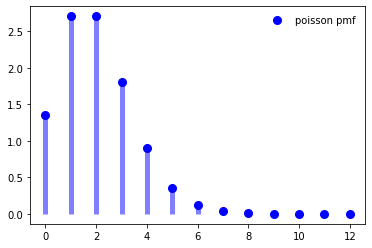

[34.0, 68.0, 68.0, 45.0, 23.0, 9.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 34.0, 68.0, 68.0, 45.0, 23.0, 9.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 34.0, 68.0, 68.0, 45.0, 23.0, 9.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 34.0, 68.0, 68.0, 45.0, 23.0, 9.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 34.0, 68.0, 68.0, 45.0, 23.0, 9.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


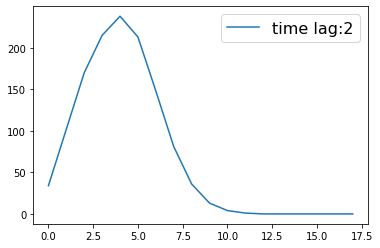